In [1]:
#import important libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# import libraries for EDA and preprocessing
import string, re, unicodedata
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import itertools
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# Train test split
from sklearn.model_selection import train_test_split

# Text pre-processing
import tensorflow as tf
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

# Evaluating
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Step 1: Brief description of the problem and data 

### 1.1 Problem

Twitter is one of social media that has become an important communication channel in different situations, for instance, in times of emergency. The smartphones enable people to announce an emergency they see in real-time. Because of that, there is an challenge that how to recognize whether a tweet text is talking about a real disaster or uses those keywords as a metaphor, which can lead to huge mislabeling of tweets. Hence, this project aims
on using Natural Language Processing (NLP) and classification models to distinguish between real and fake disaster tweets.  

To do this, first, we will inspect, visualize, clean, split train data into train (80%) and validation (20%), then tokenize the data and train three models:  

(1) Long Short Term Memory (LSTM)  
(2) Bidirectional Long Short Term Memory (Bi-LSTM)    
(3) Gated Recurrent Unit (GRU)

Then, I will compare these three deep learning models by roc_auc_score because ROC AUC is generally seen as a more important measure of how good an algorithm is. This metric considers the trade-offs between precision and recall, while Accuracy only looks at how many predictions are correct. 

Next, I will tune hyperparameter (dropout and learning rate) to get the best model and use this best model for predicting test data and print out the submission file.     

Reference Source:   
(1) https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html    
(2) https://medium.com/mlearning-ai/the-classification-of-text-messages-using-lstm-bi-lstm-and-gru-f79b207f90ad  


### 1.2 Data

In this project, I use data from Kaggle, were downloaded from the link:     
https://www.kaggle.com/competitions/nlp-getting-started/data

There are two data from this resource, included train and test data. Train data has 7613 observations and 5 columns included : id, keyword, location, text and target. Test data has 3263 observations and 4 columns included: id, keyword, location and text.

In [2]:
# read train data
df = pd.read_csv('../input/nlp-getting-started/train.csv')
#df = pd.read_csv('train.csv')

# take a look at some rows of train data
df.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# read test data
test = pd.read_csv('../input/nlp-getting-started/test.csv')
#test = pd.read_csv('test.csv')

# take a look at some rows of test data
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
# view some rows of the sample submisson
sample_submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
#sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [5]:
# the shape of train data
df.shape


(7613, 5)

In [6]:
# the shape of test data
test.shape


(3263, 4)

## Step 2: Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data

### 3.1 Inspect the data

In [7]:
# look at the first example of a not disaster tweet
fake_disaster_tweet = df[df["target"] == 0]
fake_disaster_tweet["text"].values[0]


"What's up man?"

In [8]:
# look at the first example of a disaster tweet
real_disaster_tweet = df[df["target"] == 1]
real_disaster_tweet["text"].values[0]


'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [9]:
# get a quick description of the data
df.describe()


,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [10]:
# check null values in data
df.isnull().sum()


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [11]:
# check for duplicate articles
df.duplicated(keep=False).sum()


0

In [12]:
# the structure of data also tells us the number of rows (observations) and columns (variables)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [13]:
# get the label of data
df['target'].unique()


array([1, 0])

In [14]:
# the structure of data also tells us the number of rows (observations) and columns (variables)
test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [15]:
# check null values in test data
test.isnull().sum()


id             0
keyword       26
location    1105
text           0
dtype: int64

In [16]:
# check for duplicate observations in test data
test.duplicated(keep=False).sum()


0

From the output above, we can summarize that:  
+ There are 7613 observations and 5 columns in train data. 
+ There is no missing values in "id", "text" and "target" column in train data.
+ There is no missing values in "id" and "text" column in test data.
+ There is no duplicated observations in both train and test data.  
+ There are 2 targets: 0 (fake disaster tweet) and 1 (real disaster tweet).

  

### 3.2 Visualize the data

Next, let's calculate and visualize the count and the proportion of each target.


In [17]:
# calculate the count of each target
df['target'].value_counts()


0    4342
1    3271
Name: target, dtype: int64

In [18]:
# calculate the proportion of each label
df['target'].value_counts()/len(df)*100


0    57.034021
1    42.965979
Name: target, dtype: float64

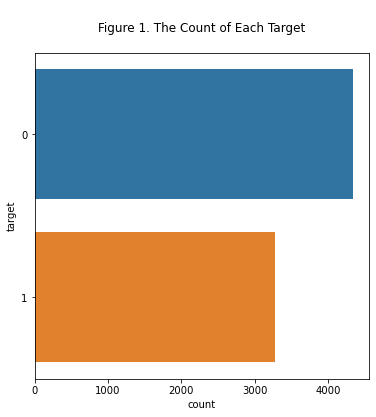

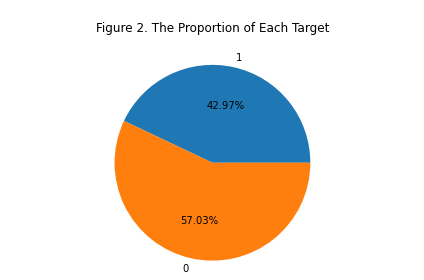

In [19]:
# plot the count of each label
fig, ax = plt.subplots(figsize=(6,6))
sns.countplot(data=df, y='target', ax=ax).set(title='\nFigure 1. The Count of Each Target\n')

# plot the proportion of each category
labels = df['target'].unique().tolist()
counts = df['target'].value_counts()
sizes = [counts[v] for v in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%0.2f%%')
ax1.axis('equal')
plt.title("\nFigure 2. The Proportion of Each Target\n")
plt.tight_layout()
plt.show()


Figure 1 shows the count of each label and figure 2 shows the proportions of each target. Looking at these two figures, we can see that in overall, the number of observations for "1" target is larger than the number of observations for "0" target. So, to solve this problem, I will balance the data by downsampling the fake disaster tweets before build models since if one or two categories was severely underrepresentated or, in contrast, overrepresentative in the train data, then it may cause our model to be biased and/or perform poorly on some or all of the test data.

### 3.3 Clean the data/ Data Preprocessing

#### 3.3.1 Clean the data

To clean the data for training models, some works has to be done such as:  
+ balance the data by downsampling the fake disaster tweets
+ drop unused columns in train data included: id, keyword and location.   

To preprocess our text simply means to bring our text into a form that is predictable and analyzable for our task. So, what I am going to do is:   

(1) lowercasing all our text data  
(2) remove number  
(3) remove links  
(4) remove punctuation      
(5) remove stop words: stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “the”, “is”, “are” and etc. The intuition behind using stop words is that, by removing low information words from text, we can focus on the important words instead.  
(6) lemmatization: lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma. For example, runs, running, ran are all forms of the word run, therefore run is the lemma of all these words.
    
Since I'm planning to redo these cleaning steps for a test data without target as well, thus for convenience, I will create a clean_text function for this data and reuse it for cleaning untargeted test data later.


In [20]:
# downsample the fake disater tweet
fake_disaster = fake_disaster_tweet.sample(n = len(real_disaster_tweet), random_state = 44)
df_news = pd.concat([fake_disaster, real_disaster_tweet], axis=0).reset_index(drop=True)
df_news["target"].value_counts()


0    3271
1    3271
Name: target, dtype: int64

In [21]:
# drop id, keyword and location columns
df_news = df_news.loc[:, ["text", "target"]]

# view some sample rows of df_news
df_news.sample(10)

,text,target
3449,Ûª93 blasts accused Yeda Yakub dies in Karach...,1
5662,Flood-zone : General Raheel Sharif visits Chit...,1
401,Being able to stay out of work this week to ta...,0
2519,@Uptown_Jorge head up like yo nose bleeding,0
2222,I want some tsunami take out,0
2239,If you ever think you running out of choices i...,0
2754,My @MLG and food worlds have collided in this ...,0
556,Govt plan for Rs40000Cr lifeline to FCI waste ...,0
1477,Vince McMahon once again a billionaire: I reme...,0
5237,.Sink Holes Earth Slides And Avalanches&gt;&gt...,1


In [22]:
def clean_text(data, text):
    # lowercasing all text data
    data[text] = data[text].str.lower()
    # remove number
    data[text] = data[text].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
    # remove links
    data[text] = data[text].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
    # remove punctuation
    data[text] = data[text].str.replace('[^\w\s]', '', regex=True)    
    # remove stop words
    stop_words = stopwords.words('english')
    data[text] = data[text].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    data[text] = data[text].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    return


In [23]:
# clean news data
clean_text(df_news, "text")

# view text in a row after cleaning all text data
df_news["text"][0]


'see inundated atm wanted say well grand job'

In [24]:
# calculate the count of word per observation
df_news["Word_Count"] = df_news['text'].apply(lambda x: len(x.split()))


In [25]:
# view some first rows of news data
df_news.head()


,text,target,Word_Count
0,see inundated atm wanted say well grand job,0,8
1,check preview danger zone coming,0,5
2,hijacking computer send data sound wave hat,0,7
3,great red spot violent storm larger entire,0,7
4,learn gained access secret top earner used exp...,0,11


In [26]:
# The average count of word per observation
print("The average count of word per observation", round(np.mean(df_news.Word_Count)))

# The maximum count of word per observation
print("The maximum count of word per observation", round(np.max(df_news.Word_Count)))

# The minimum count of word per observation
print("The minimum count of word per observation", round(np.min(df_news.Word_Count)))


The average count of word per observation 7
The maximum count of word per observation 21
The minimum count of word per observation 0


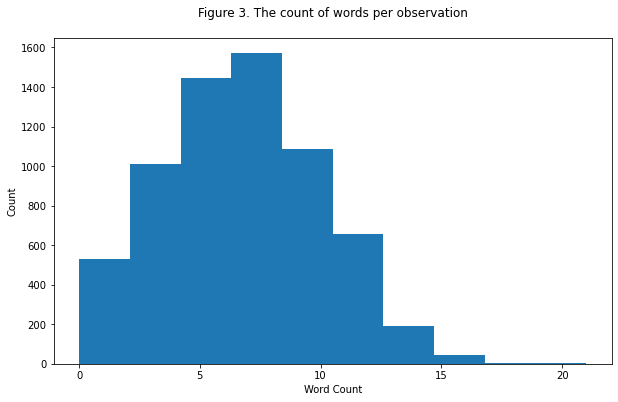

In [27]:
# plot the count of word per observation
fig, ax = plt.subplots(figsize=(10,6))
df_news['Word_Count'].plot(kind='hist')
plt.xlabel("Word Count")
plt.xticks(rotation=360)
plt.ylabel("Count")
plt.title("Figure 3. The count of words per observation\n")
plt.show()


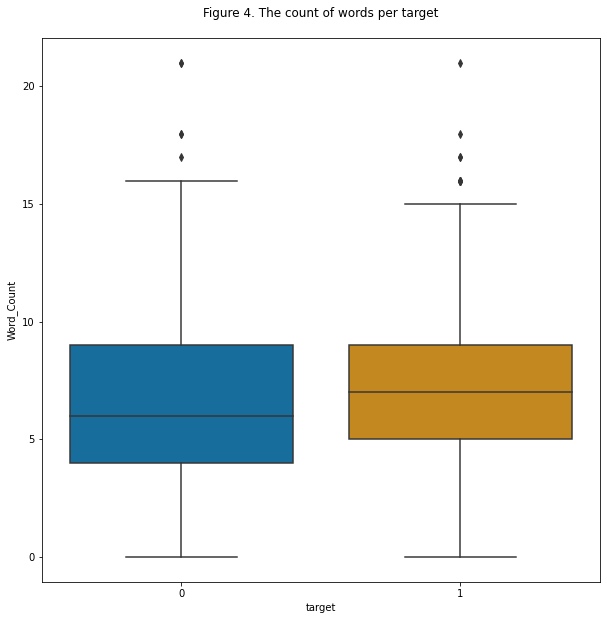

In [28]:
# visualize the count of words per label
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(data = df_news, x = 'target', y = 'Word_Count', palette = 'colorblind'
           ).set(title = 'Figure 4. The count of words per target\n')
plt.show()


Looking at figure 4, we observe that the mean and the variability of word count of fake and real disaster tweets are not different much.

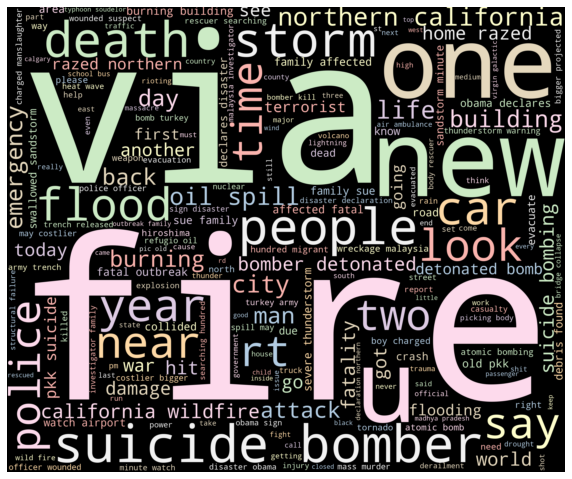

In [29]:
# Generate a word cloud image for real disaster tweets
real_disaster_text = ' '.join(df_news[df_news["target"] == 1]["text"])
real_disaster_text_cloud = WordCloud(width =3000,
                          height =2500,
                          stopwords=STOPWORDS,
                          background_color ="black",
                          colormap='Pastel1').generate(real_disaster_text)
plt.figure(figsize=(10,10))
plt.imshow(real_disaster_text_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

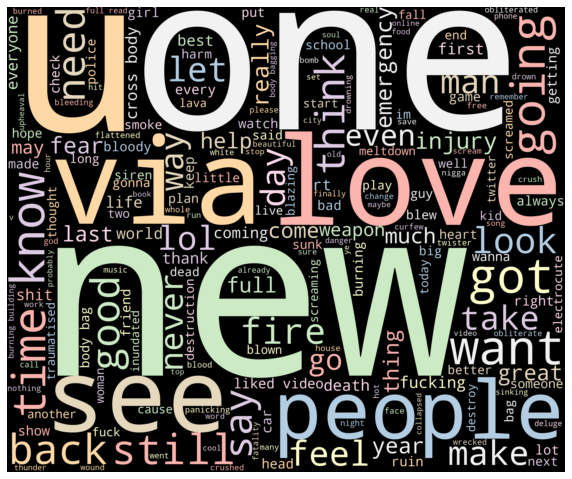

In [30]:
# Generate a word cloud image for fake disaster tweets
fake_disaster_text = ' '.join(df_news[df_news["target"] == 0]["text"])
fake_disaster_text_cloud = WordCloud(width =3000,
                          height =2500,
                          stopwords=STOPWORDS,
                          background_color ="black",
                          colormap='Pastel1').generate(fake_disaster_text)
plt.figure(figsize=(10,10))
plt.imshow(fake_disaster_text_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()


#### 3.3.2 Data Preprocessing

#### Split data

After cleaning text, to prepare for building and training models, I'll remove word_count column and split 20% of the data into validation set. Noted that, I'll use sklearn train_test_split to split the data, with default shuffle = True and stratify=target, means this method will split our data into random train and validation subsets and have the same proportion of target in df_news. 


In [31]:
# drop word_count column 
df_news = df_news.drop(columns='Word_Count')


In [32]:
X = df_news["text"]
Y = df_news["target"]

In [33]:
# shuffle and split the data into train and test set
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, 
                                                      shuffle=True, 
                                                      random_state = 42,
                                                      stratify=df_news.target)

# get shape of train and validation dataset after splitting
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(5233,) (5233,)
(1309,) (1309,)


Text data requires a special approach to machine learning. This is because text data can have hundreds of thousands of dimensions (words and phrases) but tends to be very sparse. Machines, unlike humans, cannot understand the raw text. Machines can only see numbers. Particularly, statistical techniques such as machine learning can only deal with numbers. Therefore, we need to convert the text data into numerical representation, so the model will understand it.

Different approaches exist to convert text into the corresponding numerical form such as: Tokenization, Vectorization or Bag-of-Words. In this case I will use Tokenization with Keras to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. I choose this method because Keras open-source library is one of the most reliable deep learning frameworks. To perform tokenization we use: text_to_word_sequence method from the Class Keras.preprocessing.text class. The great thing about Keras is converting the alphabet in a lower case before tokenizing it, which can be quite a time-saver. Some hyperparameters for performing tokenization:

+ num_words: means how many unique word that we want to load in training and testing data
+ oov_token: means out of vocabulary token will be added to word index in the corpus which is used to build the model. This is used to replace out of vocabulary words (words that are not in our corpus) during text_to_sequence calls.
+ pad_type = 'post': means our maximum sentence length will be determined by searching our sentences for the one of maximum length, and padding characters will be '0'.
+ trunc_type = 'post': means our sentence sequence numeric representations corresponding to word index entries will appear at the left-most positions of our resulting sentence vectors, while the padding characters ('0') will appear after our actual data at the right-most positions of our resulting sentence vectors.


In [34]:
vocab_size = len(set(" ".join(X).split()))
pad_type = 'post'
trunc_type = 'post'
oov_token = '<OOV>'


In [35]:
# Tokenize our training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)

# Get our training data word index
word_index = tokenizer.word_index

# Encode x_train text into sequences
train_sequences = tokenizer.texts_to_sequences(x_train)

# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

# Output the results of our work
print("Length of Word index:\n", len(word_index))
print("\nLength of Training sequences:\n", len(train_sequences))
print("\nPadded training sequences:\n", train_padded)
print("\nPadded training shape:", train_padded.shape)


Length of Word index:
 8225

Length of Training sequences:
 5233

Padded training sequences:
 [[3679 3680   12 ...    0    0    0]
 [ 444    0    0 ...    0    0    0]
 [1576 3681  188 ...    0    0    0]
 ...
 [  26    0    0 ...    0    0    0]
 [ 426    0    0 ...    0    0    0]
 [  32  320 1471 ...    0    0    0]]

Padded training shape: (5233, 21)


Now let's use our tokenizer to tokenize the validation data, and then similarly encode our sequences. Note that we are using the same tokenizer we created for training in order to facilitate simpatico between the 2 datasets, using the same vocabulary. We also pad to the same length and specifications as the training sequences.

In [36]:
valid_sequences = tokenizer.texts_to_sequences(x_valid)
valid_padded = pad_sequences(valid_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

print("Length of Validation sequences:\n", len(valid_sequences))
print("\nPadded Validation sequences:\n", valid_padded)
print("\nPadded Validation shape:",valid_padded.shape)

Length of Validation sequences:
 1309

Padded Validation sequences:
 [[3472   77    1 ...    0    0    0]
 [1421 1261 7028 ...    0    0    0]
 [ 887 4594    0 ...    0    0    0]
 ...
 [ 211    1 1915 ...    0    0    0]
 [  62 7745   21 ...    0    0    0]
 [2291 1197  549 ...    0    0    0]]

Padded Validation shape: (1309, 21)


In [37]:
# check out some first rows of the encoded validation data
for x, y in zip(x_valid[:10], valid_padded[:10]):
    print('{} -> {}'.format(x, y))

magic city kissimmee adventure -> [3472   77    1    1    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]
daughter shadow warrior woman aka transgender mode p nyc fold extra extra center bioterrorism -> [1421 1261 7028   82 1545    1  991 2206 1405 7235 4403 4403  596  720
    0    0    0    0    0    0    0]
hey esh -> [ 887 4594    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]
pov video capture violent landing amsterdam airport schiphol storm daily mail -> [1721   22  755  209  649 2161  473 2814   25  687 1963    0    0    0
    0    0    0    0    0    0    0]
knew gon happen -> [1480 5814 1306    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]
nearly heart attack loud bang window next two bird flying -> [ 625  260   57  189  382 1199  145   42 2249 2675    0    0    0    0
    0    0    0    0    0    0    0]
pray attack enemy derail ur destiny blocked lord 

In [38]:
# view first 100 word indexes
print("\nWord index (for reference):", dict(itertools.islice(word_index.items(), 100)))


Word index (for reference): {'<OOV>': 1, 'like': 2, 'fire': 3, 'get': 4, 'via': 5, 'new': 6, 'u': 7, 'one': 8, 'people': 9, 'disaster': 10, 'family': 11, 'emergency': 12, 'body': 13, 'police': 14, 'year': 15, 'still': 16, 'home': 17, 'suicide': 18, 'say': 19, 'building': 20, 'burning': 21, 'video': 22, 'would': 23, 'train': 24, 'storm': 25, 'see': 26, 'time': 27, 'california': 28, 'car': 29, 'look': 30, 'know': 31, 'man': 32, 'got': 33, 'killed': 34, 'nuclear': 35, 'first': 36, 'going': 37, 'day': 38, 'go': 39, 'bomb': 40, 'dead': 41, 'two': 42, 'crash': 43, 'love': 44, 'make': 45, 'death': 46, 'may': 47, 'take': 48, 'war': 49, 'news': 50, 'life': 51, 'flood': 52, 'could': 53, 'bombing': 54, 'want': 55, 'back': 56, 'attack': 57, 'watch': 58, 'collapse': 59, 'world': 60, 'need': 61, 'many': 62, 'full': 63, 'good': 64, 'think': 65, 'kill': 66, 'last': 67, 'rt': 68, 'accident': 69, 'today': 70, 'northern': 71, 'bomber': 72, 'obama': 73, 'never': 74, 'service': 75, 'way': 76, 'city': 77, 

## Step 4: Building and training models

### 4.1 Long Short Term Memory (LSTM)

Long Short Term Memory (LSTM) was designed to overcome the problems of simple Recurrent Neural Network (RNN) by allowing the network to store data in a sort of memory that it can access at a later times. The key of the LSTM model is the cell state. The cell state is updated twice with few computations that resulting stabilize gradients. It has also a hidden state that acts like a short term memory.  

In LSTM there are Forget Gate, Input Gate and Output Gate.

(1) The first step is to decide what information we’re going to throw away from the cell state. This decision is made by a sigmoid layer called the “Forget Gate” layer.   
(2) The second step is to decide what new information that we’re going to store in the cell state. This has two parts. First, a sigmoid layer called the “Input Gate” layer decides which values we’ll update. Next, a tanh layer which creates a vector of new candidate values that could be added to the state.   
(3) Finally, we need to decide what we are going to output. This output will be based on our cell state, but will be a filtered version. First, we run a sigmoid layer which decides what parts of the cell state we’re going to output. Then, we put the cell state through tanh (to push the values to be between -1 and 1) and multiply it by the output of the sigmoid gate, so that we only output the parts we decided.   

We use the binary_crossentropy as a loss function because the output of the model is binary and for the optimizer, we use adam which makes use of momentum to avoid local minima.  
 
+ epoch : number of times the learning algorithm will work through the entire training data.
+ callbacks : to pass the early stopping parameter. EarlyStopping(monitor=’val_loss’, patience=3) was used to define that we want to monitor the validation loss and if the validation loss is not improved after 3 epochs, then the model training will stop. This technique helps to avoid overfitting problem.
+ verbose : 2 , it will show us the number of epoch, loss and accuracy on each epoch.

In [39]:
# Define the LSTM model architecture

# Define parameter
n_lstm = 21
embedding_dim = 32
max_len = train_padded.shape[1]
drop_lstm = 0.2
vocab_size = len(word_index)

In [40]:
# Define LSTM Model 
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model1.add(SpatialDropout1D(drop_lstm))
model1.add(LSTM(n_lstm, return_sequences=False))
model1.add(Dropout(drop_lstm))
model1.add(Dense(1, activation='sigmoid'))

# summary model1
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 32)            263200    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 21, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 21)                4536      
_________________________________________________________________
dropout (Dropout)            (None, 21)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 22        
Total params: 267,758
Trainable params: 267,758
Non-trainable params: 0
_________________________________________________________________


In [41]:
# compile the model
model1.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [42]:
num_epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=3)
mp = ModelCheckpoint(filepath='model1_cp', monitor='val_loss', save_best_only=True)
history1 = model1.fit(train_padded,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(valid_padded, y_valid),
                     callbacks =[early_stop, mp],
                     verbose=2)

Epoch 1/10
164/164 - 5s - loss: 0.6463 - accuracy: 0.5964 - val_loss: 0.4984 - val_accuracy: 0.7662
Epoch 2/10
164/164 - 1s - loss: 0.4056 - accuracy: 0.8313 - val_loss: 0.4893 - val_accuracy: 0.7777
Epoch 3/10
164/164 - 1s - loss: 0.2787 - accuracy: 0.8968 - val_loss: 0.5294 - val_accuracy: 0.7624
Epoch 4/10
164/164 - 1s - loss: 0.2045 - accuracy: 0.9333 - val_loss: 0.6091 - val_accuracy: 0.7479
Epoch 5/10
164/164 - 1s - loss: 0.1660 - accuracy: 0.9436 - val_loss: 0.6565 - val_accuracy: 0.7594


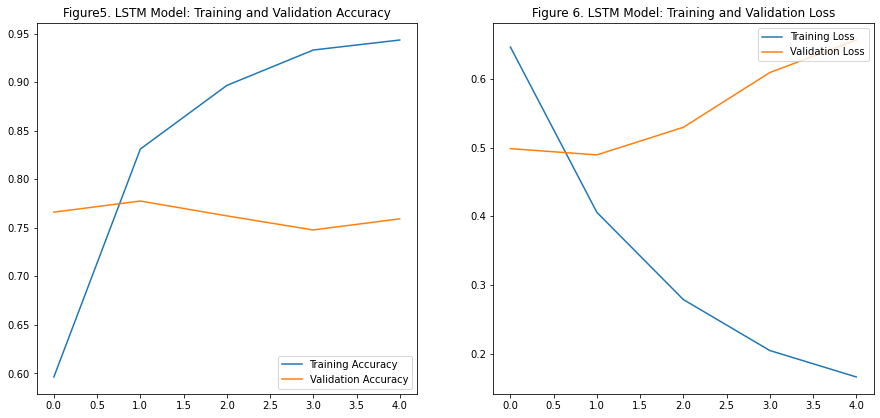

In [43]:
# plot the graph of accuracy
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc1, label='Training Accuracy')
plt.plot(epochs_range, val_acc1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Figure5. LSTM Model: Training and Validation Accuracy')

# plot the graph of loss
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss1, label='Training Loss')
plt.plot(epochs_range, val_loss1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Figure 6. LSTM Model: Training and Validation Loss')
plt.show()

### 4.2 Bidirectional Long Short Term Memory (Bi-LSTM)

A Bidirectional LSTM, or biLSTM, is a sequence processing model that consists of two LSTMs: one taking the input in a forward direction, and the other in a backwards direction. BiLSTMs effectively increase the amount of information available to the network, improving the context available to the algorithm (e.g. knowing what words immediately follow and precede a word in a sentence). Unlike standard LSTM, the input flows of Bi-LSTM in both directions, and it’s capable of utilizing information from both sides. It’s also a powerful tool for modeling the sequential dependencies between words and phrases in both directions of the sequence.

BiLSTM adds one more LSTM layer, which reverses the direction of information flow. Briefly, it means that the input sequence flows backward in the additional LSTM layer. Then we combine the outputs from both LSTM layers in several ways, such as average, sum, multiplication, or concatenation.


In [44]:
# define Bi_LSTM model
model2 = Sequential()
model2.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model2.add(Bidirectional(LSTM(n_lstm,
                              return_sequences = False)))
model2.add(Dropout(drop_lstm))
model2.add(Dense(1, activation='sigmoid'))

# summary model2
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 32)            263200    
_________________________________________________________________
bidirectional (Bidirectional (None, 42)                9072      
_________________________________________________________________
dropout_1 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 43        
Total params: 272,315
Trainable params: 272,315
Non-trainable params: 0
_________________________________________________________________


In [45]:
# compile model2
model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy'])

In [46]:
# train model2
num_epochs = 10
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 3)
mp = ModelCheckpoint(filepath='model2_cp', monitor='val_loss', save_best_only=True)
history2 = model2.fit(train_padded,
                     y_train,
                     epochs = num_epochs,
                     validation_data = (valid_padded, y_valid),
                     callbacks = [early_stop, mp],
                     verbose = 2)

Epoch 1/10
164/164 - 4s - loss: 0.6308 - accuracy: 0.6486 - val_loss: 0.4965 - val_accuracy: 0.7617
Epoch 2/10
164/164 - 1s - loss: 0.3759 - accuracy: 0.8374 - val_loss: 0.5061 - val_accuracy: 0.7739
Epoch 3/10
164/164 - 1s - loss: 0.2449 - accuracy: 0.9066 - val_loss: 0.5992 - val_accuracy: 0.7510
Epoch 4/10
164/164 - 1s - loss: 0.1752 - accuracy: 0.9388 - val_loss: 0.6401 - val_accuracy: 0.7555


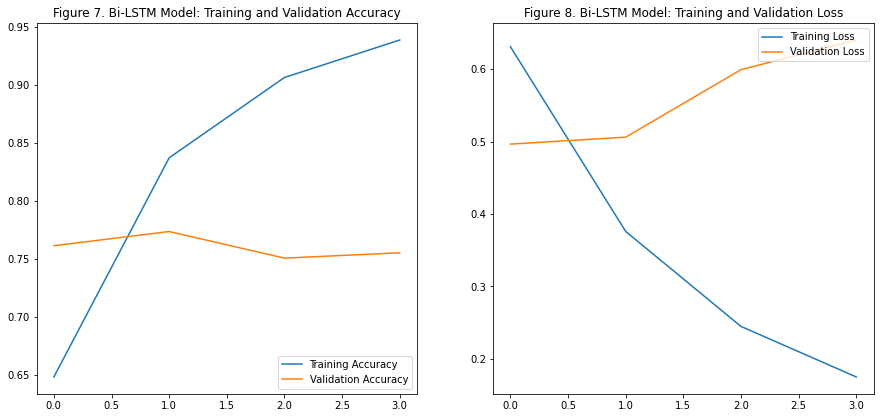

In [47]:
# plot the graph of accuracy
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range = range(4)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc2, label='Training Accuracy')
plt.plot(epochs_range, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Figure 7. Bi-LSTM Model: Training and Validation Accuracy')

# plot the graph of loss
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss2, label='Training Loss')
plt.plot(epochs_range, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Figure 8. Bi-LSTM Model: Training and Validation Loss')
plt.show()

### 4.3 Gated Recurrent Unit (GRU)

A Gated Recurrent Unit, or GRU, is a type of recurrent neural network. It is similar to an LSTM, but only has two gates — a reset gate and an update gate and notably lacks an output gate. Fewer parameters means GRUs are generally easier/faster to train than their LSTM counterparts.

In [48]:
# define GRU model
model3 = Sequential()
model3.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model3.add(SpatialDropout1D(0.2))
model3.add(GRU(128, return_sequences = False))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation = 'sigmoid'))

# summary model3
model3.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 21, 32)            263200    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 21, 32)            0         
_________________________________________________________________
gru (GRU)                    (None, 128)               62208     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 325,537
Trainable params: 325,537
Non-trainable params: 0
_________________________________________________________________


In [49]:
# compile model3
model3.compile(loss = 'binary_crossentropy',
                       optimizer = 'adam',
                       metrics=['accuracy'])


In [50]:
# train model3
num_epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=3)
mp = ModelCheckpoint(filepath='model3_cp', monitor='val_loss', save_best_only=True)
history3 = model3.fit(train_padded,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(valid_padded, y_valid),
                     callbacks =[early_stop, mp],
                     verbose=2)

Epoch 1/10
164/164 - 2s - loss: 0.6938 - accuracy: 0.4915 - val_loss: 0.6933 - val_accuracy: 0.5004
Epoch 2/10
164/164 - 1s - loss: 0.6730 - accuracy: 0.5418 - val_loss: 0.5080 - val_accuracy: 0.7571
Epoch 3/10
164/164 - 1s - loss: 0.4331 - accuracy: 0.8095 - val_loss: 0.4734 - val_accuracy: 0.7731
Epoch 4/10
164/164 - 1s - loss: 0.2975 - accuracy: 0.8840 - val_loss: 0.5336 - val_accuracy: 0.7456
Epoch 5/10
164/164 - 1s - loss: 0.2153 - accuracy: 0.9236 - val_loss: 0.5929 - val_accuracy: 0.7548
Epoch 6/10
164/164 - 1s - loss: 0.1640 - accuracy: 0.9419 - val_loss: 0.7497 - val_accuracy: 0.7380


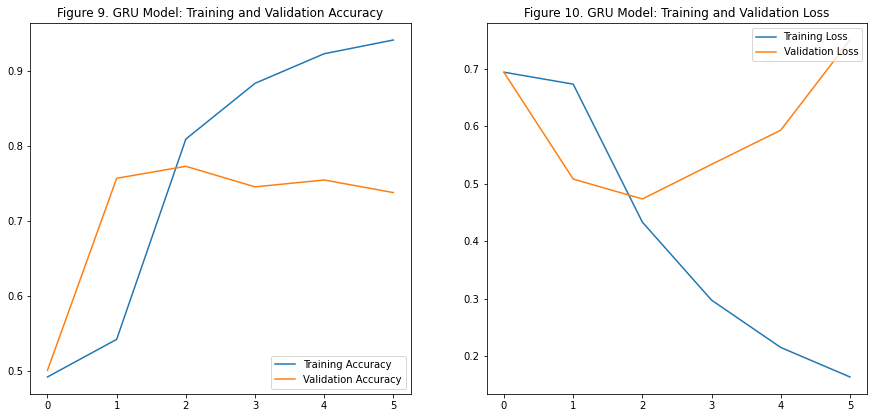

In [52]:
# plot the graph of accuracy
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

epochs_range = range(6)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc3, label='Training Accuracy')
plt.plot(epochs_range, val_acc3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Figure 9. GRU Model: Training and Validation Accuracy')

# plot the graph of loss
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss3, label='Training Loss')
plt.plot(epochs_range, val_loss3, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Figure 10. GRU Model: Training and Validation Loss')
plt.show()


## Step 4: Results and Analysis

### 4.1 Results

#### Model 1

In [53]:
# get loss and accuracy score
score1 = model1.evaluate(valid_padded, y_valid)
print('LSTM model loss:', score1[0])
print('LSTM model accuracy:', score1[1])

41/41 [==============================] - 0s 2ms/step - loss: 0.6565 - accuracy: 0.7594
LSTM model loss: 0.6565138101577759
LSTM model accuracy: 0.759358286857605


In [54]:
# calculate validation roc_acc_score 
y_pred1 = model1.predict(valid_padded)
v_auc_score1 = roc_auc_score(y_valid, y_pred1)
print('LSTM model roc_auc_score:', v_auc_score1)

LSTM model roc_auc_score: 0.8273793683031025


In [55]:
# make predictions on the validation dataset
y_pred1 = np.where(y_pred1 > 0.5, 1, 0)

# print out classification report
print(classification_report(y_valid, y_pred1))


              precision    recall  f1-score   support

           0       0.73      0.83      0.77       655
           1       0.80      0.69      0.74       654

    accuracy                           0.76      1309
   macro avg       0.76      0.76      0.76      1309
weighted avg       0.76      0.76      0.76      1309



<AxesSubplot:>

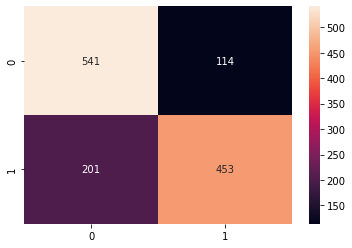

In [56]:
# print out the confusion matrix
cm1 = confusion_matrix(y_valid, y_pred1)
sns.heatmap(cm1, annot=True, fmt=".0f")


#### Model 2

In [57]:
# get loss and accuracy score
score2 = model2.evaluate(valid_padded, y_valid)
print('Bi-LSTM model loss:', score2[0])
print('Bi-LSTM model accuracy:', score2[1])


41/41 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.7555
Bi-LSTM model loss: 0.6401122212409973
Bi-LSTM model accuracy: 0.7555385828018188


In [58]:
# calculate validation roc_acc_score 
y_pred2 = model2.predict(valid_padded)
v_auc_score2 = roc_auc_score(y_valid, y_pred2)
print('LSTM model roc_auc_score:', v_auc_score2)


LSTM model roc_auc_score: 0.8285174031794944


In [59]:
# make predictions on the validation dataset
y_pred2 = np.where(y_pred2 > 0.5, 1, 0)

# print out classification report
print(classification_report(y_valid, y_pred2))


              precision    recall  f1-score   support

           0       0.73      0.81      0.77       655
           1       0.79      0.70      0.74       654

    accuracy                           0.76      1309
   macro avg       0.76      0.76      0.75      1309
weighted avg       0.76      0.76      0.75      1309



<AxesSubplot:>

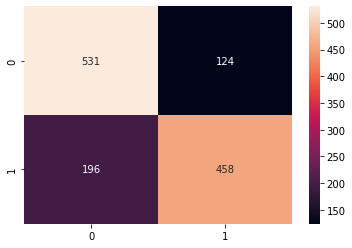

In [60]:
# print out the confusion matrix
cm2 = confusion_matrix(y_valid, y_pred2)
sns.heatmap(cm2, annot=True, fmt=".0f")


#### Model 3

In [61]:
# get loss and accuracy score
score3 = model3.evaluate(valid_padded, y_valid)
print('GRU model loss:', score3[0])
print('GRU model accuracy:', score3[1])


41/41 [==============================] - 0s 3ms/step - loss: 0.7497 - accuracy: 0.7380
GRU model loss: 0.7497482299804688
GRU model accuracy: 0.7379679083824158


In [62]:
# calculate validation roc_acc_score 
y_pred3 = model3.predict(valid_padded)
v_auc_score3 = roc_auc_score(y_valid, y_pred3)
print('LSTM model roc_auc_score:', v_auc_score3)


LSTM model roc_auc_score: 0.8263078646964073


In [63]:
# make predictions on the validation dataset
y_pred3 = np.where(y_pred3 > 0.5, 1, 0)

# print out classification report
print(classification_report(y_valid, y_pred3))


              precision    recall  f1-score   support

           0       0.74      0.73      0.73       655
           1       0.73      0.75      0.74       654

    accuracy                           0.74      1309
   macro avg       0.74      0.74      0.74      1309
weighted avg       0.74      0.74      0.74      1309



<AxesSubplot:>

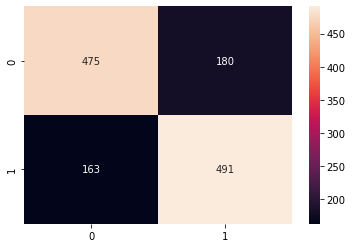

In [64]:
# print out the confusion matrix
cm3 = confusion_matrix(y_valid, y_pred3)
sns.heatmap(cm3, annot=True, fmt=".0f")


### 4.2 Comparing the three different models


In [65]:
# create compare dataframe to compare three models
models = {'Model': ["LSTM", "Bi_LSTM", "GRU"],
        'Accuracy': [score1[1], score2[1], score3[1]],
        'Loss': [score1[0], score2[0], score3[0]],
         'roc_auc_score': [v_auc_score1, v_auc_score2, v_auc_score3]}
compare_data = pd.DataFrame(models)
compare_data = compare_data.sort_values(by='roc_auc_score', ascending = False, ignore_index=True)
print("Compare three deep learning models: ")
display(compare_data)


Compare three deep learning models: 


,Model,Accuracy,Loss,roc_auc_score
0,Bi_LSTM,0.755539,0.640112,0.828517
1,LSTM,0.759358,0.656514,0.827379
2,GRU,0.737968,0.749748,0.826308


We observe that Bi-LSTM is the best model with higher best roc_auc_score and least loss validation.

### 4.3 Run Dropout and Learning Rate Tuning 

Dropout is a technique where randomly selected neurons are ignored during training. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass, and any weight updates are not applied to the neuron on the backward pass.

When we have training data, if we try to train your model too much, it might overfit, and dropout regularization is one technique used to tackle overfitting problems in deep learning.  

Because our above result shows that Bi_LSTM is the best model, so now I would like to use Bi-LSTM model with trying 3 different Dropout: [0.2, 0.3, 0.5] and learning rate: [0.001, 0.0001, 0.00001].  

Because we are creating many models in a loop, this global state will consume an increasing amount of memory over time, so we should clear it. Calling clear_session() releases the global state: this helps avoid clutter from old models and layers, especially when memory is limited.  

In [66]:
# tuning dropout and learning rate for GRU model
for dropout in [0.2, 0.3, 0.5]:
    for lr in [0.001, 0.0001, 0.00001]:
    #  clear session:\
        tf.keras.backend.clear_session()

        # define new model
        new_model = Sequential()
        new_model.add(Embedding(vocab_size,
                         embedding_dim,
                         input_length = max_len))
        new_model.add(Bidirectional(LSTM(n_lstm,
                              return_sequences = False)))
        new_model.add(Dropout(dropout))
        new_model.add(Dense(1, activation='sigmoid'))

        # compile new model
        opt = tf.keras.optimizers.Adam(learning_rate = lr)
        new_model.compile(loss = 'binary_crossentropy',
                            optimizer = opt,
                            metrics=['accuracy'])

        # train new model
        num_epochs = 10
        new_history = new_model.fit(train_padded,
                             y_train,
                             epochs=num_epochs, 
                             validation_data=(valid_padded, y_valid),
                             verbose=0)
        # best result
        y_pred = new_model.predict(valid_padded)
        v_auc_score = roc_auc_score(y_valid, y_pred)
        print("Best roc_auc_score for Dropout: ", dropout, "and learning rate: ", lr, "is: ", v_auc_score)


Best roc_auc_score for Dropout:  0.2 and learning rate:  0.001 is:  0.8163165020893153
Best roc_auc_score for Dropout:  0.2 and learning rate:  0.0001 is:  0.8315124775311062
Best roc_auc_score for Dropout:  0.2 and learning rate:  1e-05 is:  0.7237621682190629
Best roc_auc_score for Dropout:  0.3 and learning rate:  0.001 is:  0.818910054392231
Best roc_auc_score for Dropout:  0.3 and learning rate:  0.0001 is:  0.837510796741135
Best roc_auc_score for Dropout:  0.3 and learning rate:  1e-05 is:  0.6792072273968766
Best roc_auc_score for Dropout:  0.5 and learning rate:  0.001 is:  0.8124039965450429
Best roc_auc_score for Dropout:  0.5 and learning rate:  0.0001 is:  0.8377734201741485
Best roc_auc_score for Dropout:  0.5 and learning rate:  1e-05 is:  0.6487499124588556


From the result above, we can see that Bi-LSTM with dropout: 0.5 and learning rate 0.0001 is the best model, has roc_auc_score of 0.83777.

### 4.3 Use the best model to predict test data without target

Now, we will use the best model to predict test data. Some works need to be done as:
+ clean text in test data
+ tokenizing text
+ use best model for predicting test data
+ create submission file

In [67]:
# clean test data
clean_text(test, "text")

# view text in a row after cleaning all text data
test["text"][0]


'happened terrible car crash'

In [68]:
# tokenization for test set
test_sequences = tokenizer.texts_to_sequences(test["text"])
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

print("Length of Test sequences:\n", len(test_sequences))
print("\nPadded Test sequences:\n", test_padded)
print("\nPadded Test shape:",test_padded.shape)


Length of Test sequences:
 3263

Padded Test sequences:
 [[ 616 1520   29 ...    0    0    0]
 [ 258  942  373 ...    0    0    0]
 [ 101    3  632 ...    0    0    0]
 ...
 [ 968  494  485 ...    0    0    0]
 [6906  263  372 ...    0    0    0]
 [1937  867   12 ...    0    0    0]]

Padded Test shape: (3263, 21)


In [69]:
# train best model
best_model = Sequential()
best_model.add(Embedding(vocab_size,
                 embedding_dim,
                 input_length = max_len))
best_model.add(Bidirectional(LSTM(n_lstm,
                              return_sequences = False)))
best_model.add(Dropout(0.5))
best_model.add(Dense(1, activation='sigmoid'))

# compile new model
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
best_model.compile(loss = 'binary_crossentropy',
                    optimizer = opt,
                    metrics=['accuracy'])

# train new model
num_epochs = 10
best_history = best_model.fit(train_padded,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(valid_padded, y_valid),
                     verbose=2)

Epoch 1/10
164/164 - 4s - loss: 0.6923 - accuracy: 0.5297 - val_loss: 0.6914 - val_accuracy: 0.6211
Epoch 2/10
164/164 - 1s - loss: 0.6902 - accuracy: 0.5838 - val_loss: 0.6887 - val_accuracy: 0.6700
Epoch 3/10
164/164 - 1s - loss: 0.6848 - accuracy: 0.6618 - val_loss: 0.6817 - val_accuracy: 0.6853
Epoch 4/10
164/164 - 1s - loss: 0.6715 - accuracy: 0.6813 - val_loss: 0.6649 - val_accuracy: 0.7235
Epoch 5/10
164/164 - 1s - loss: 0.6284 - accuracy: 0.7397 - val_loss: 0.5759 - val_accuracy: 0.7380
Epoch 6/10
164/164 - 1s - loss: 0.4436 - accuracy: 0.8177 - val_loss: 0.4998 - val_accuracy: 0.7617
Epoch 7/10
164/164 - 1s - loss: 0.3473 - accuracy: 0.8712 - val_loss: 0.5183 - val_accuracy: 0.7548
Epoch 8/10
164/164 - 1s - loss: 0.2975 - accuracy: 0.8980 - val_loss: 0.5406 - val_accuracy: 0.7594
Epoch 9/10
164/164 - 1s - loss: 0.2578 - accuracy: 0.9186 - val_loss: 0.5567 - val_accuracy: 0.7601
Epoch 10/10
164/164 - 1s - loss: 0.2278 - accuracy: 0.9341 - val_loss: 0.5951 - val_accuracy: 0.7555

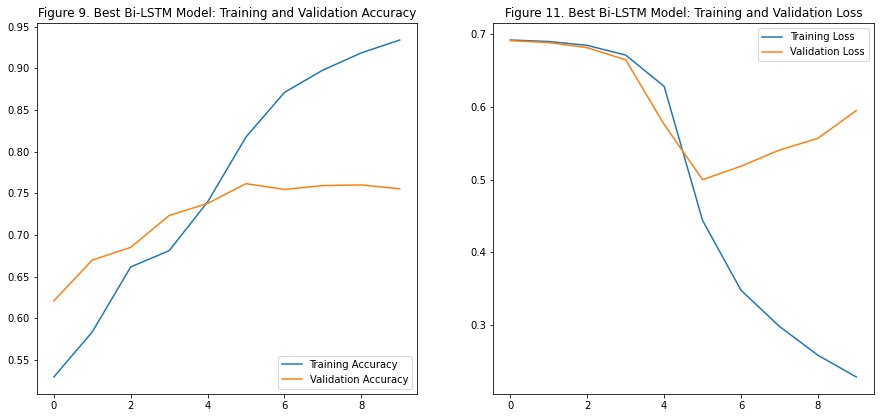

In [70]:
# plot the graph of accuracy
best_acc = best_history.history['accuracy']
best_val_acc = best_history.history['val_accuracy']
best_loss = best_history.history['loss']
best_val_loss = best_history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, best_acc, label='Training Accuracy')
plt.plot(epochs_range, best_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Figure 9. Best Bi-LSTM Model: Training and Validation Accuracy')

# plot the graph of loss
plt.subplot(2, 2, 2)
plt.plot(epochs_range, best_loss, label='Training Loss')
plt.plot(epochs_range, best_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Figure 11. Best Bi-LSTM Model: Training and Validation Loss')
plt.show()


In [71]:
# predict test data
y_pred = best_model.predict(test_padded)
test_predictions = np.where(y_pred > 0.5, 1, 0)

In [72]:
# create dataframe of result
submission = pd.DataFrame()
submission['id'] = test['id']
submission['target'] = test_predictions
submission.head()


,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [73]:
# view test prediction counts
submission['target'].value_counts()


0    2101
1    1162
Name: target, dtype: int64

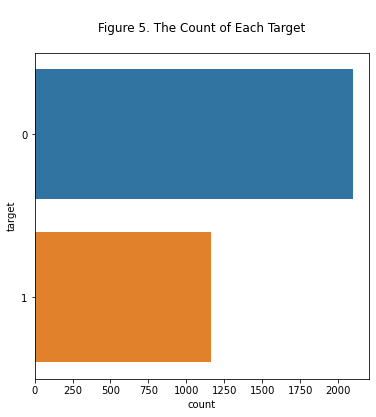

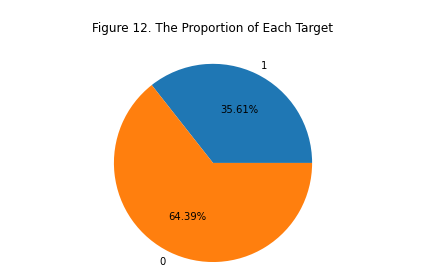

In [74]:
# plot the count of each label
fig, ax = plt.subplots(figsize=(6,6))
sns.countplot(data=submission, y='target', ax=ax).set(title='\nFigure 5. The Count of Each Target\n')

# plot the proportion of each label
labels = submission['target'].unique().tolist()
counts = submission['target'].value_counts()
sizes = [counts[v] for v in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%0.2f%%')
ax1.axis('equal')
plt.title("\nFigure 12. The Proportion of Each Target\n")
plt.tight_layout()
plt.show()


In [75]:
# convert to csv to submit to competition
submission.to_csv('best_model_submission.csv', index=False)


## Step 5: Conclusion and Takeaways

In this project, there are 5 parts:  

(1) Brief description of the problem and data.     
(2) EDA - Inspect, Visualize, and Clean the data.    
(3) Building and training models:   
+ LSTM 
+ Bi-LSTM  
+ GRU    
 
(4) Results and Analysis.  
(5) Conclusion.     

The goal of this project is to detect fake and real disaster tweets. By comparing three different deep learning models including: LSTM, Bi-LSTM and GRU, we can conclude that in this case, the Bi-LSTM model is the model that has the best performance with the highest roc_auc_score value of 0.828517 and the least loss value of 0.640112. After tuning dropout and learning rate for Bi-LSTM model, we can see that the roc_auc_score increases to 0.83777 with dropout = 0.5 and learning rate = 0.0001, this is the best model we got. Then we used this best model for predicting test data.

I think this result is good, however, because of the limitation of data and the running time was too costly, the models just were trained on limited approach. I believe there are many other ways can improve this kind of project such as: building more deep learning models by tuning other hyperparameters to get optimal results, or we can run models with more epoch, or use other type of Word Embeddings such as: Vectorization or Bag-of-Words. 


Because of the curiosity, I would like to print out the predictions of all three models above and let's see how these model's performance are.

In [76]:
# use three deep learning models predict test set and print out the submission 

for m in ["model1", "model2", "model3"]:
    model = tf.keras.models.load_model(f'{m}_cp')
    
    # predict test data
    y_pred = model.predict(test_padded)
    test_predictions = np.where(y_pred > 0.5, 1, 0)
    
    # create dataframe of result
    submission = pd.DataFrame()
    submission['id'] = test['id']
    submission['target'] = test_predictions
    submission.to_csv(f'{m}_submission.csv', index=False)

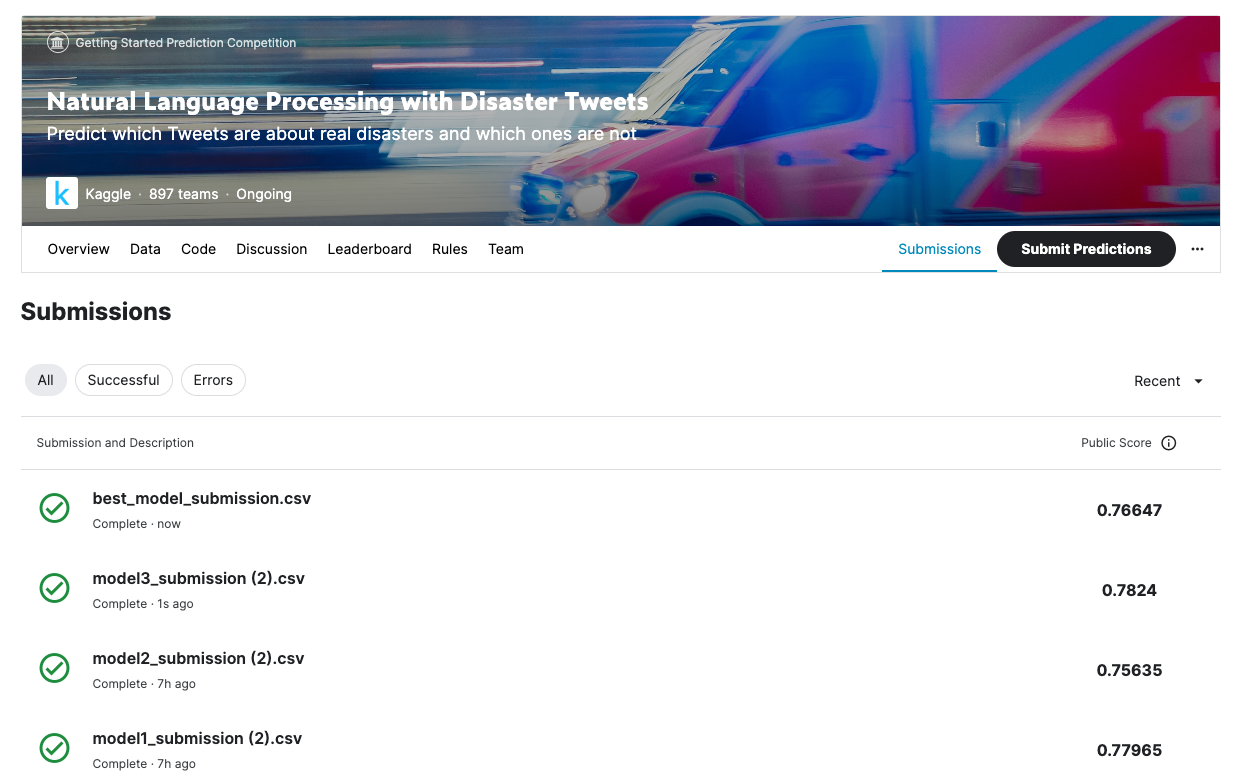

It's interesting that model 3 (GRU) has best score.